# Forecasting methods



In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
import os

from main.utils.utils_methods import *
from main.utils.utils import *
import statsmodels.api as sm
from pmdarima.arima import auto_arima

import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
from main.module.mlp_multioutput import mlp_multioutput


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We will simulate a time series from the following ARIMA process:
$$
y_t = 0.75 y_{t-1} + 0.25 y_{t-2} + 0.65 \varepsilon_{t-1} + 0.35 \varepsilon_{t-2} + \varepsilon_t
$$

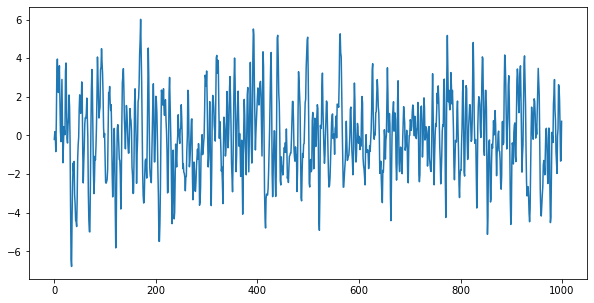

In [27]:
np.random.seed(12345)

# ARMA parameters
arparams = np.array([.75, -.25])
maparams = np.array([.65, .35])
ar_term = np.r_[1, -arparams] # add zero-lag and negate
ma_term = np.r_[1, maparams] # add zero-lag
arma_process = sm.tsa.ArmaProcess(ar_term, ma_term)

y = arma_process.generate_sample(1000)
plt.plot(y)

Fit an ARMA model to the simulated time series using auto_arima. Do you recover the true parameters? To obtain details about your model fit, you can use the following functions: summary(), arparams(), and maparams().

In [28]:

model = auto_arima(y)
print(model.summary())

print(model.arparams())
print(-ar_term[1:])
print(model.maparams())
print(ma_term[1:])


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1000
Model:               SARIMAX(2, 0, 2)   Log Likelihood               -1398.466
Date:                Thu, 10 Dec 2020   AIC                           2806.931
Time:                        19:49:43   BIC                           2831.470
Sample:                             0   HQIC                          2816.258
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7012      0.075      9.383      0.000       0.555       0.848
ar.L2         -0.2353      0.060     -3.910      0.000      -0.353      -0.117
ma.L1          0.6982      0.072      9.724      0.0

Change the default parameters of the auto_arima function to get faster results. Eploit the fact that you know the "true" model (see above).

In [ ]:

model = auto_arima(y, 
                            d = 0,

                            start_p = 2, 
                            max_p = 2, 
                            start_q = 2, 
                            max_q = 2, 

                            D = 0,

                            start_P=0,
                            max_P=0, 
                            start_Q=0, 
                            max_Q=0,      
                            seasonal = False)
print(model.summary())
print(model.arparams())
print(-ar_term[1:])
print(model.maparams())
print(ma_term[1:])


# Neural network forecast

In the following, we will consider two neural network architectures for forecasting. Your task is to play with all the hyperparameters to obtain the best out-of-sample forecasts, i.e. on the test set.

Some important hyperparameters include: n_simul (size of the dataset), LAG (the number of lagged values), LATENT_DIM (the number of units in the layer), BATCH_SIZE (number of samples per mini-batch), EPOCHS (the number of epochs), the optimizer and the early stop strategy.

The dataset you will use is a time series simulated from a non-linear time series model. See below. 

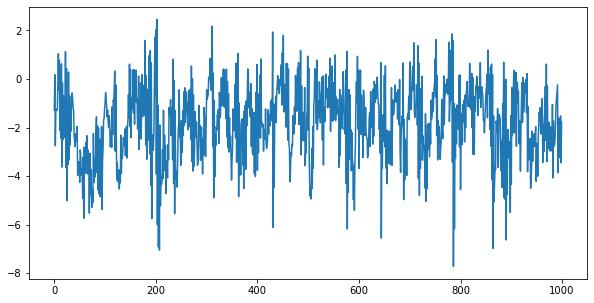

In [29]:
n_simul = 1000
n_burn = 100
n = n_simul + n_burn
noise = np.random.normal(size = n)

y = np.zeros(n)
y[0] = 0; y[1] = 0
for t in range(2, n):
    y[t] = 0.3 * y[t - 1] + 0.6 * y[t - 2] + (0.1 - 0.9 * y[t - 1] + 0.8 * y[t - 2]) * (1/( 1 + np.exp(- 10 * y[t - 1]) )) + noise[t]

data = pd.DataFrame(y[n_burn:], columns = ["series"])
plt.plot(data)

Choose which loss function you want to experiment with. It is used later in the code to fit and evaluate a neural network model.

In [30]:
# Loss function to be used to optimize the model parameters
loss_fct = 'mse' # 'mae'
# Accuracy measure to be used to evaluate test predictions.
accuracy_measure = mse # mae # mape # smape

In [31]:
# The forecast horizon
HORIZON = 3

# The number of lagged values.
LAG = 4

# Data split
n = len(data)
n_train = int(0.6 * n)
n_valid = int(0.2 * n)
n_learn = n_train + n_valid

train = data[:n_train]
valid = data[n_train:n_learn]
test = data[n_learn:n]

# From time series to input-output data (also called time series embedding)
train_inputs, valid_inputs, test_inputs, \
    X_train, y_train, X_valid, y_valid, \
        X_test, y_test = embed_data(train, valid, test, HORIZON, LAG, freq = None, variable = 'series')


Read and try to understand the function *mlp_multioutput*. What kind of neural network architecture does it return?

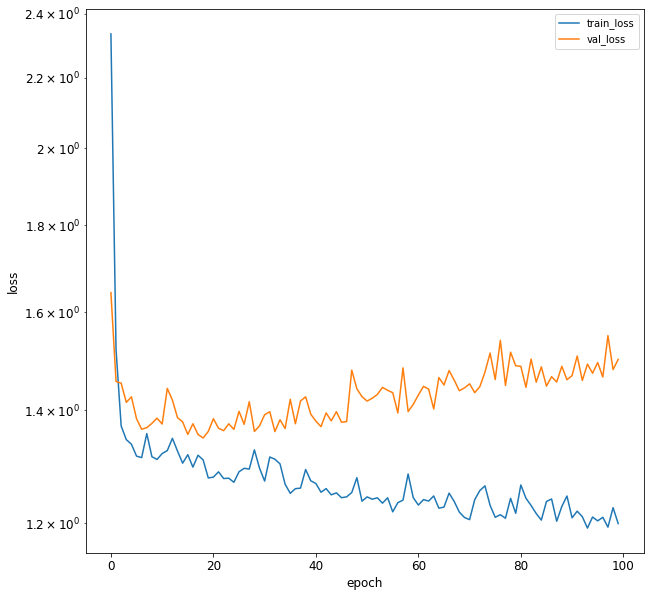

In [33]:
#########################
file_header = "model_" + "mlp_multioutput"
verbose = 0

optimizer_adam = keras.optimizers.Adam(learning_rate=0.01) 
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience= 100)

LATENT_DIM = 50 #5   # number of units in the RNN layer
BATCH_SIZE = 32  # number of samples per mini-batch
EPOCHS = 100      # maximum number of times the training algorithm will cycle through all samples
loss = loss_fct

best_val = ModelCheckpoint('../work/' + file_header + '_{epoch:02d}.h5', save_best_only=True, mode='min', period=1)
#########################

model_mlp_multioutput, history_mlp_multioutput = mlp_multioutput(X_train, y_train, X_valid, y_valid, 
                        LATENT_DIM = LATENT_DIM, 
                        BATCH_SIZE = BATCH_SIZE, 
                        EPOCHS = EPOCHS, 
                        LAG = LAG, 
                        HORIZON = HORIZON, 
                        loss = loss, 
                        optimizer = optimizer_adam,
                        earlystop = earlystop, 
                        best_val = best_val,
                        verbose=verbose)
plot_learning_curves(history_mlp_multioutput)

best_epoch = np.argmin(np.array(history_mlp_multioutput.history['val_loss']))+1
filepath = '../work/' + file_header + '_{:02d}.h5'
model_mlp_multioutput.load_weights(filepath.format(best_epoch))

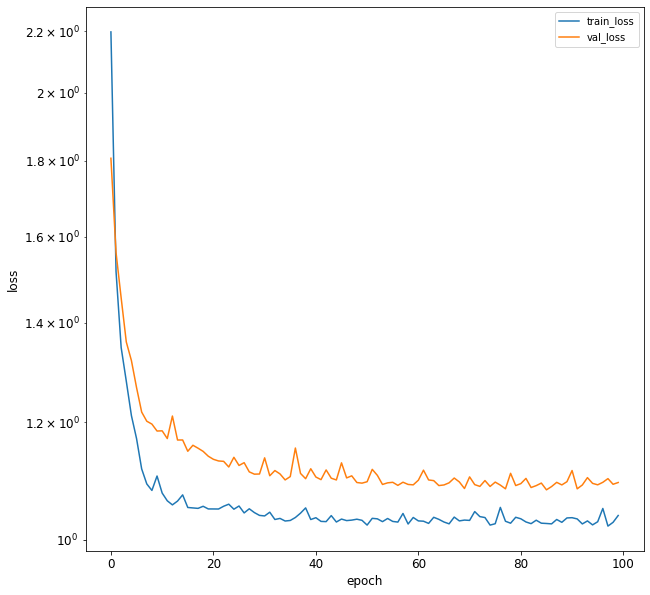

In [34]:
 #########################
file_header = "model_" + "mlp_recursive"
verbose = 0

optimizer_adam = keras.optimizers.Adam(learning_rate=0.01) 
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience= 100)

LATENT_DIM = 5   # number of units in the RNN layer
BATCH_SIZE = 32  # number of samples per mini-batch
EPOCHS = 100      # maximum number of times the training algorithm will cycle through all samples
loss = loss_fct

best_val = ModelCheckpoint('../work/' + file_header + '_{epoch:02d}.h5', save_best_only=True, mode='min', period=1)
#########################
 
 _, _, _, X_train_onestep, y_train_onestep, X_valid_onestep, y_valid_onestep, _, _ = embed_data(train, valid, test, 1, LAG, freq = None, variable = 'series')
model_mlp_recursive, history_mlp_recursive = mlp_multioutput(X_train_onestep, y_train_onestep, X_valid_onestep, y_valid_onestep, 
                        LATENT_DIM = LATENT_DIM, 
                        BATCH_SIZE = BATCH_SIZE, 
                        EPOCHS = EPOCHS, 
                        LAG = LAG, 
                        HORIZON = 1, 
                        loss = loss, 
                        optimizer = optimizer_adam,
                        earlystop = earlystop, 
                        best_val = best_val,
                        verbose=verbose)
plot_learning_curves(history_mlp_recursive)

best_epoch = np.argmin(np.array(history_mlp_recursive.history['val_loss']))+1
filepath = '../work/' + file_header + '_{:02d}.h5'
model_mlp_recursive.load_weights(filepath.format(best_epoch))


In [35]:
#len(X_test.values[:, -1])
predictions_naive = np.tile(X_test.values[:, -1], (HORIZON, 1) ).T
predictions_naive = pd.DataFrame(predictions_naive, columns=['t+'+str(t) for t in range(1, HORIZON+1)])
print(predictions_naive)


          t+1       t+2       t+3
0   -2.706032 -2.706032 -2.706032
1   -1.062761 -1.062761 -1.062761
2   -1.278663 -1.278663 -1.278663
3   -1.761596 -1.761596 -1.761596
4   -0.869337 -0.869337 -0.869337
..        ...       ...       ...
189 -3.857373 -3.857373 -3.857373
190 -1.597842 -1.597842 -1.597842
191 -3.233714 -3.233714 -3.233714
192 -2.795984 -2.795984 -2.795984
193 -2.879464 -2.879464 -2.879464

[194 rows x 3 columns]


In [36]:
#
predictions_mlp_multioutput = model_mlp_multioutput.predict(X_test)
predictions_mlp_multioutput = pd.DataFrame(predictions_mlp_multioutput, columns=['t+'+str(t) for t in range(1, HORIZON+1)])

#
for h in range(HORIZON):
    pred = model_mlp_recursive.predict(X_test)
    X_test = pd.DataFrame(np.hstack( (np.delete(X_test.to_numpy(), 0, 1), pred) ), index = X_test.index, columns =X_test.columns)
    if h > 0:
        predictions_mlp_recursive = np.hstack( (predictions_mlp_recursive, pred) )
    else:
        predictions_mlp_recursive = pred
predictions_mlp_recursive = pd.DataFrame(predictions_mlp_recursive, columns=['t+'+str(t) for t in range(1, HORIZON+1)])

predictions_combination = (predictions_mlp_multioutput + predictions_mlp_recursive)/2

print(predictions_mlp_multioutput)
print(predictions_mlp_recursive)

          t+1       t+2       t+3
0   -2.263058 -2.182278 -1.957547
1   -1.837043 -1.313649 -1.753186
2   -0.949168 -1.331898 -1.214620
3   -1.269065 -1.504683 -1.261515
4   -1.238474 -0.985178 -1.293510
..        ...       ...       ...
189 -0.963064 -3.326170 -1.824309
190 -2.875917 -1.932882 -2.566389
191 -1.733467 -2.605623 -1.591593
192 -2.882318 -2.230232 -2.514010
193 -2.413328 -2.404129 -2.240099

[194 rows x 3 columns]
          t+1       t+2       t+3
0   -2.142411 -2.201697 -1.864481
1   -1.859625 -1.105939 -1.394596
2   -0.913201 -0.974923 -0.766011
3   -1.250634 -1.371243 -1.084896
4   -1.252254 -0.819419 -0.938138
..        ...       ...       ...
189 -1.089744 -2.632738 -1.342207
190 -2.799604 -1.706991 -2.150097
191 -1.849980 -2.462322 -1.770316
192 -2.759104 -2.431050 -2.314626
193 -2.478082 -2.410993 -2.142118

[194 rows x 3 columns]


In [37]:
true_values = pd.DataFrame(test_inputs["target"], columns=['t+'+str(t) for t in range(1, HORIZON+1)])

results_naive = list()
results_mlp_multioutput = list()
results_mlp_recursive = list()
results_combination = list()


for h in range(1, HORIZON+1):
    time_horizon = 't+'+ str(h)
    results_naive.append(accuracy_measure(true_values[time_horizon], predictions_naive[time_horizon]))
    results_mlp_multioutput.append(accuracy_measure(true_values[time_horizon], predictions_mlp_multioutput[time_horizon]))
    results_mlp_recursive.append(accuracy_measure(true_values[time_horizon], predictions_mlp_recursive[time_horizon]))
    results_combination.append(accuracy_measure(true_values[time_horizon], predictions_combination[time_horizon]))


print(np.mean(results_naive))
print(np.mean(results_mlp_multioutput))
print(np.mean(results_mlp_recursive))
print(np.mean(results_combination))

#print( mape(true_values.to_numpy().T.ravel(), predictions_mlp.to_numpy().T.ravel()) )



3.0763763536101627
1.3486200400378026
1.4232612242388327
1.3709544705594094
